# Model 1: Deterministic Baseline

This model provides a transparent baseline to visualize 
trade-offs (cost, plant type, capacity) assuming perfect, single-period information. It identifies 
the optimal plant mix that meets demand at minimum capital cost for one time period, using 
known (deterministic) inputs. The analysis evaluates all technologies by cost and efficiency, 
comparing the impact of building a few large units versus many smaller ones. This establishes 
a reference point, showing the most cost-efficient technologies under ideal conditions and 
identifying binding constraints (like budget or fuel limits).

##### Notebook Outline
1) Imports
2) Load Input Data
3) Scenario Parameters
4) Gurobi Model Setup
5) Results
6) Visualizations
7) Dual Analysis

### Imports

In [81]:
import json
from pathlib import Path
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

### Load input data

In [82]:
data_path = Path("data") / "technology_data.json"

with data_path.open("r", encoding="utf-8") as f:
    technology_data = json.load(f)

TECHNOLOGY_UNITS = technology_data["TECHNOLOGY_UNITS"]  
TECHNOLOGY_DATA = technology_data["TECHNOLOGY_DATA"]

df_units = pd.DataFrame(list(TECHNOLOGY_UNITS.items()), columns=["Parameter", "Unit"])
df_tech = pd.DataFrame(TECHNOLOGY_DATA).reset_index().rename(columns={"index": "parameter"})
df = df_units.merge(df_tech, left_on="Parameter", right_on="parameter", how="right").drop(columns=["parameter"])
df

,Parameter,Unit,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
0,nominal_investment_total,MEUR/MW_el,0.36,0.47,2.10,4.000,1.150,2.390,0.38
1,fixed_om_total,EUR/MW/year,8983.37,8236.12,34324.40,147700.000,16663.000,34000.000,9500.00
2,variable_om_total,EUR/MWh,6.38,4.79,3.21,20.000,0.000,0.000,0.00
3,elec_eff,fraction (0-1),0.35,0.41,0.52,0.360,0.410,0.520,0.16
4,technical_lifetime,years,25.00,25.00,25.00,60.000,30.000,30.000,35.00
5,construction_time,years,1.00,0.20,4.50,8.000,1.500,3.500,0.50
6,total_outage,fraction of time (0-1),0.01,0.01,0.00,0.001,0.023,0.025,NaN


### Scenario Parameters

In [83]:
# Define the initial budget (in MEUR)
initial_budget = 500  # The total available budget for investment in MW

# Assumed energy demand (in MWh), will not be used for meeting demand directly in this case
# Instead, we focus on energy mix selection based on budget and cost minimization
total_energy_mix = 1000000  # in MWh

# Define a large constant for big-M method
M = 1000000  # Large number to enforce energy production only when selected

# Hours in the year
hours_per_year = 8760

### Gurobi Model Setup

#### Variables

In [84]:
model = gp.Model("Optimal_Plant_Mix")

# Define decision variables for each technology
tech_names = list(TECHNOLOGY_DATA.keys())
investment_vars = model.addVars(tech_names, vtype=GRB.CONTINUOUS, name="Investment")

# Total installed capacity for each technology in MW (decision variable)
energy_produced_vars = model.addVars(tech_names, vtype=GRB.CONTINUOUS, name="EnergyProduced")

# Define binary variables to track if a technology is producing energy
binary_vars = model.addVars(tech_names, vtype=GRB.BINARY, name="BinaryProduced")


#### Model constraints

In [85]:
# 1. Ensure total annualized CAPEX stays within the initial budget
model.addConstr(
    gp.quicksum(
        investment_vars[tech] * TECHNOLOGY_DATA[tech]['nominal_investment_total'] for tech in tech_names
    ) <= initial_budget,  # Total investment must not exceed budget
    "Budget_Constraint"
)

# 2. Ensure the total energy produced by the selected technologies equals the required energy mix
model.addConstr(
    gp.quicksum(
        energy_produced_vars[tech] for tech in tech_names
    ) == total_energy_mix,  # Total energy produced should match the target energy mix
    "EnergyMix_Constraint"
)

# 3. Ensure at least 4 different technologies are selected
# Sum of binary variables should be at least 4
model.addConstr(
    gp.quicksum(
        binary_vars[tech] for tech in tech_names
    ) >= 4,  # At least 4 technologies must be producing energy
    "MinTechnologies_Constraint"
)

# 4. Ensure each selected technology produces at least 10% of the total energy mix
# Big-M method to link the energy production with the binary variable
model.addConstrs(
    (energy_produced_vars[tech] >= 0.1 * total_energy_mix * binary_vars[tech] for tech in tech_names)
    , name="MinTechnologyContribution"
)

# 5. The energy produced by each technology cannot exceed its installed capacity
model.addConstrs(
    (energy_produced_vars[tech] <= investment_vars[tech] * hours_per_year * TECHNOLOGY_DATA[tech]['elec_eff'] for tech in tech_names)
    , name="MaxCapacity_Constraint"
)

# 6. Link binary variable with energy production (a binary variable is 1 if energy is produced, 0 otherwise)
# Using big-M to activate energy production only when binary variable is 1
model.addConstrs(
    (energy_produced_vars[tech] <= M * binary_vars[tech] for tech in tech_names)
    , name="BinaryLink"
)

{'Diesel engine farm': <gurobi.Constr *Awaiting Model Update*>,
 'OCGT - Natural gas': <gurobi.Constr *Awaiting Model Update*>,
 'Coal power plant': <gurobi.Constr *Awaiting Model Update*>,
 'Nuclear power plant': <gurobi.Constr *Awaiting Model Update*>,
 'Onshore wind': <gurobi.Constr *Awaiting Model Update*>,
 'Offshore wind (fixed)': <gurobi.Constr *Awaiting Model Update*>,
 'Utility-scale PV': <gurobi.Constr *Awaiting Model Update*>}

#### Objective Function + optimize

In [86]:
# Objective: Minimize the total annualized cost (CAPEX + O&M)
model.setObjective(
    gp.quicksum(
        investment_vars[tech] * (TECHNOLOGY_DATA[tech]['nominal_investment_total']/TECHNOLOGY_DATA[tech]['technical_lifetime']) for tech in tech_names
    ) +  # CAPEX cost in MEUR  --  devided by lifetime to annualize
    gp.quicksum(
        energy_produced_vars[tech] * (TECHNOLOGY_DATA[tech]['variable_om_total']/1000000) for tech in tech_names
    ),  # Variable O&M cost in MEUR
    GRB.MINIMIZE
)
# Solve the model
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 PRO 7840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24 rows, 21 columns and 63 nonzeros
Model fingerprint: 0xe5a8c1a6
Variable types: 14 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+06]
  Objective range  [3e-06, 8e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 1e+06]
Presolve removed 7 rows and 7 columns
Presolve time: 0.00s
Presolved: 17 rows, 14 columns, 49 nonzeros
Variable types: 7 continuous, 7 integer (7 binary)
Found heuristic solution: objective 14.4038050
Found heuristic solution: objective 12.3525827

Root relaxation: objective 8.599791e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth In

#### Results

In [87]:
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    print(f"Total annual cost: {model.objVal:.2f} MEUR")
    print("\nDetailed cost per technology:")
    print("-------------------------------------------------------------")

    for tech in tech_names:
        cap = investment_vars[tech].x
        gen = energy_produced_vars[tech].x

        if gen > 0:
            capex_total = cap * TECHNOLOGY_DATA[tech]['nominal_investment_total']
            capex_annual = capex_total / TECHNOLOGY_DATA[tech]['technical_lifetime']
            vom_annual = gen * TECHNOLOGY_DATA[tech]['variable_om_total'] / 1_000_000

            print(f"{tech}")
            print(f"  Installed capacity: {cap:.2f} MW")
            print(f"  Energy produced:    {gen:,.0f} MWh/year")
            print(f"  Total CAPEX:        {capex_total:.2f} MEUR")
            print(f"  Annual CAPEX:       {capex_annual:.2f} MEUR/year")
            print(f"  Variable O&M:       {vom_annual:.2f} MEUR/year")
            print(f"  Share of demand:    {100*gen/total_energy_mix:.2f}%")
            print("-------------------------------------------------------------")

Optimal solution found:
Total annual cost: 8.60 MEUR

Detailed cost per technology:
-------------------------------------------------------------
Diesel engine farm
  Installed capacity: 32.62 MW
  Energy produced:    100,000 MWh/year
  Total CAPEX:        11.74 MEUR
  Annual CAPEX:       0.47 MEUR/year
  Variable O&M:       0.64 MEUR/year
  Share of demand:    10.00%
-------------------------------------------------------------
OCGT - Natural gas
  Installed capacity: 27.84 MW
  Energy produced:    100,000 MWh/year
  Total CAPEX:        13.09 MEUR
  Annual CAPEX:       0.52 MEUR/year
  Variable O&M:       0.48 MEUR/year
  Share of demand:    10.00%
-------------------------------------------------------------
Onshore wind
  Installed capacity: 27.84 MW
  Energy produced:    100,000 MWh/year
  Total CAPEX:        32.02 MEUR
  Annual CAPEX:       1.07 MEUR/year
  Variable O&M:       0.00 MEUR/year
  Share of demand:    10.00%
-------------------------------------------------------------

#### Visualizations

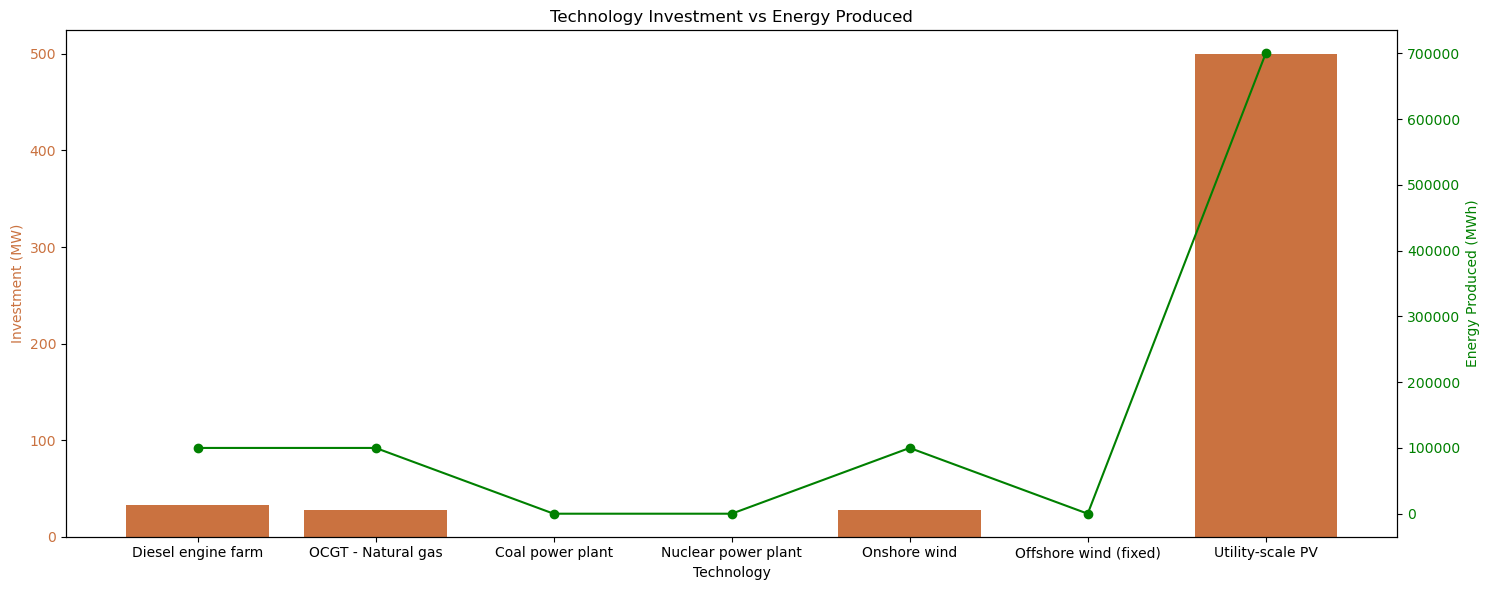

In [88]:
import matplotlib.pyplot as plt

# Data for visualization
tech_names = list(TECHNOLOGY_DATA.keys())
investment_values = [investment_vars[tech].x for tech in tech_names]
energy_produced_values = [energy_produced_vars[tech].x for tech in tech_names]

# Plotting
fig, ax1 = plt.subplots(figsize=(15, 6))

# Bar plot for investments
ax1.bar(tech_names, investment_values, color="#CA7240", label='Investment (MW)')
ax1.set_xlabel('Technology')
ax1.set_ylabel('Investment (MW)', color="#CA7240")
ax1.tick_params(axis='y', labelcolor="#CA7240")

# Create a second y-axis for energy produced
ax2 = ax1.twinx()
ax2.plot(tech_names, energy_produced_values, color='green', marker='o', label='Energy Produced (MWh)')
ax2.set_ylabel('Energy Produced (MWh)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and layout
plt.title('Technology Investment vs Energy Produced')
fig.tight_layout()

# Show the plot
plt.show()



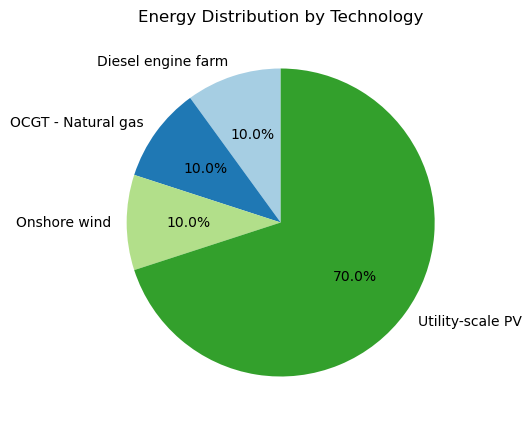

In [89]:
# Filter out technologies with zero energy produced
contributing_technologies = [(tech, energy) for tech, energy in zip(tech_names, energy_produced_values) if energy > 0]

# Prepare data for the pie chart
techs = [tech for tech, _ in contributing_technologies]
energy_produced = [energy for _, energy in contributing_technologies]

# Plotting the pie chart
plt.figure(figsize=(5, 5))
plt.pie(energy_produced, labels=techs, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Energy Distribution by Technology')

# Display the plot
plt.show()


## Dual analysis:

In [90]:
# Create LP relaxation of the model
lp = model.relax()
lp.setParam('Presolve', 0)
lp.optimize()


print("\n--- DUALS FROM LP RELAXATION ---\n")


# ===============================
# EXTRACT DUALS FOR BOTH CONSTRAINT FAMILIES
# ===============================
min_contrib_duals = []
max_capacity_duals = []

for tech in tech_names:
    c1 = lp.getConstrByName(f"MinTechnologyContribution[{tech}]")
    c2 = lp.getConstrByName(f"MaxCapacity_Constraint[{tech}]")
    min_contrib_duals.append(c1.Pi if c1 is not None else 0.0)
    max_capacity_duals.append(c2.Pi if c2 is not None else 0.0)

Set parameter Presolve to value 0
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 PRO 7840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
Presolve  0

Optimize a model with 24 rows, 21 columns and 63 nonzeros
Model fingerprint: 0x4d9a5149
Coefficient statistics:
  Matrix range     [4e-01, 1e+06]
  Objective range  [3e-06, 8e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 1e+06]

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.816128e+04   0.000000e+00      0s
      17    8.5997905e+00   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.599790532e+00

--- DUALS FROM LP RELAXATION ---



### Visualization of results

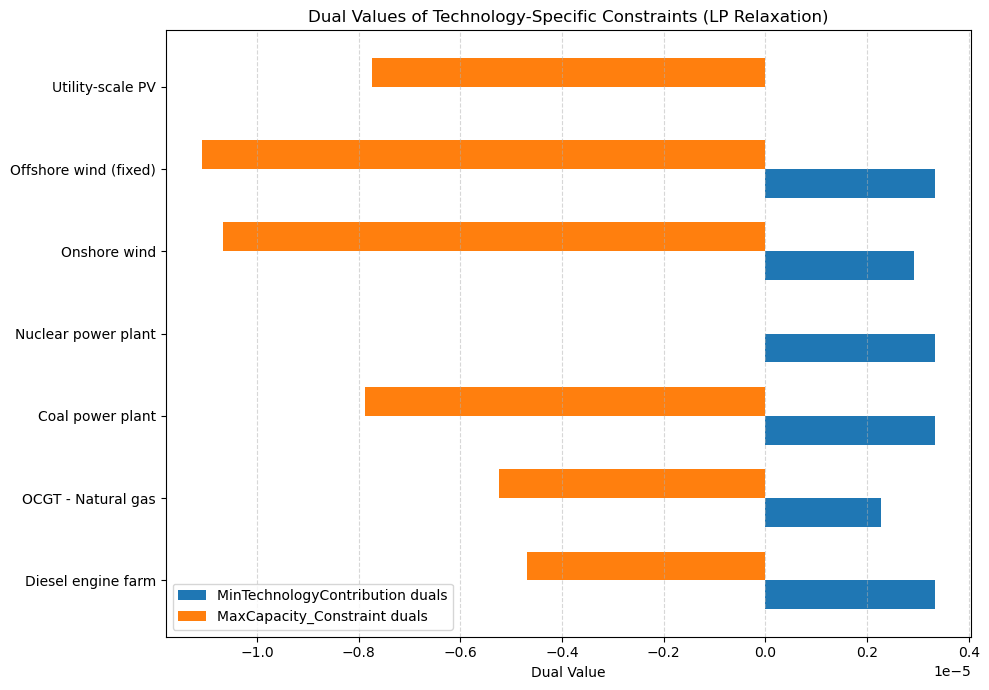

In [91]:
# ===============================
# HORIZONTAL BAR PLOT (BOTH DUAL FAMILIES)
# ===============================

import numpy as np

y_pos = np.arange(len(tech_names))  # positions for bars
height = 0.35                       # thickness of each bar

plt.figure(figsize=(10, 7))

# MinContribution bar (positive duals)
plt.barh(
    y_pos - height/2, 
    min_contrib_duals,
    height=height,
    label='MinTechnologyContribution duals'
)

# MaxCapacity bar (negative duals)
plt.barh(
    y_pos + height/2, 
    max_capacity_duals,
    height=height,
    label='MaxCapacity_Constraint duals'
)

plt.yticks(y_pos, tech_names)
plt.xlabel("Dual Value")
plt.title("Dual Values of Technology-Specific Constraints (LP Relaxation)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show(block=True)